# 1. Introduction

In this section, we will develop and evaluate various machine learning models to predict nightly price.

## 1.1 Dataset Preparation

The data cleaning and wrangling steps are presented in the milestone report.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_columns',500)

df = pd.read_csv('data/listings.csv')

C:\Users\georg\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
##3.1 Data type correction

#String to numeric

col_to_numeric = ['price','security_deposit','cleaning_fee','extra_people']

for col in col_to_numeric:
    df[col] = df[col].str.replace('$','').str.replace(',','').astype(float)

df.host_response_rate = df.host_response_rate.str.replace('%','').astype(float)/100

#String to datetime

col_to_datetime = ['last_scraped','host_since','calendar_last_scraped','first_review','last_review']

for col in col_to_datetime:
    df[col] = pd.to_datetime(df[col])

## 3.2 Incorrect Price Data Elimination
df = df[df.price > 0]


## 3.3 Missing Values Imputation
size = df.shape[0]
missing_cnt = df.isnull().sum()
missing_pct = missing_cnt/size*100
df_missing = pd.concat([missing_cnt,missing_pct],axis=1)
df_missing.columns = ['Missing Count','Missing Percentage']
# save file, to be used later
df_missing[df_missing['Missing Count']>0].sort_values('Missing Count', ascending=False).to_csv('data/missing_summary.csv')

#Numeric Features - (1)
for col in ['host_listings_count','bathrooms','host_response_rate','bedrooms','beds']:
    df[col+'_NA'] = np.where(df[col].isnull(),1, 0)
    m = df[col].median()
    df[col].fillna(m,inplace=True)
    
#Numeric Features (2)
for col in ['security_deposit','cleaning_fee']:
    df[col+'_NA'] = np.where(df[col].isnull(),1, 0)
    df[col].fillna(0,inplace=True)
    
#Numeric Features (3)
for col in ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']:
    df[col+'_NA'] = np.where(df[col].isnull(),1, 0)
    df[col].fillna(df[col].median(),inplace=True)

#Categorical Features
for col in ['host_response_time', 'host_is_superhost','host_identity_verified','host_has_profile_pic']:

    df[col+"_NA"] = np.where(df[col].isnull(),1,0)
    df[col].fillna(df[col].mode().iloc[0],inplace=True)

#Datetime Features
for col in ['host_since', 'first_review', 'last_review']:
    df[col+"_NA"] = np.where(df[col].isnull(),1,0)
    df[col].fillna(df[col].quantile(0.5),inplace=True)
    
## 3.4 New Feature Creation
### 3.4.1 City Names
# Create new column for FSA
df['fsa'] = df.zipcode.str.slice(stop=3).str.upper()

# read in fsa-city data (Wikipedia) 
toronto_fsa = pd.read_csv('data/toronto_fsa.csv')

#create a dictionary with postcode as key and borough (city) as dictionary
fsa_dict = {i:j for i,j in zip(toronto_fsa.Postcode, toronto_fsa.Borough)}

#create new column that maps the FSA to the city name
df['city_fsa'] = np.nan
df['city_fsa'] = df.fsa.map(fsa_dict)

# Create a list of indexes for unknown
idx_nan = df.loc[df.city_fsa.isnull() == True].index

# Create list of "Not assigned"
idx_not_assigned = df.loc[df.city_fsa == 'Not assigned'].index

# Create list of rare cities to confirm location with mapquest api
#set threshold to be 1% of all data

threshold = df.shape[0] * 0.01
rare_city_list = df.city_fsa.value_counts()[df.city_fsa.value_counts() < threshold].index
idx_rare = df.loc[df.city_fsa.apply(lambda x: x in rare_city_list)].index

idx_set = set()
for idx in [idx_nan,idx_not_assigned,idx_rare]:
    idx_set.update(idx)

#convert to list so the order is consistent
idx_list = list(idx_set)

#impute df city_fsa information with api collected data

file = 'data/city_rev_geocode_df.csv'
city_rev_geocode_df = pd.read_csv(file, index_col=0)
for idx in city_rev_geocode_df.index:
    df.loc[idx,'fsa'] = city_rev_geocode_df.loc[idx,'fsa']
    df.loc[idx,'city_fsa'] = city_rev_geocode_df.loc[idx,'city']
    
file = 'data/city_rev_geocode_df.csv'
city_rev_geocode_df = pd.read_csv(file, index_col=0)

#Drop nan
df = df.loc[df.city_fsa.notnull()]

#Drop Minority City
city_list = ['Downtown Toronto','Central Toronto','East Toronto','West Toronto','York','North York','East York','Scarborough','Etobicoke']
city_filter = df.city_fsa.apply(lambda x: x in city_list)
df = df.loc[city_filter]

###3.4.2 Indicator Variable for Anemities

df['amenities_list'] = df['amenities'].str.lower().str.replace('[{}"]','').str.split(',')
amenities_set = set()
for i in df['amenities_list']:
    amenities_set.update(i)
amenities_set.remove('')
for item in amenities_set:
    df[item] = df.amenities_list.apply(lambda x: 1 if item in x else 0)

df.drop('amenities_list',axis=1,inplace=True)
    
size = df.shape[0]
count = []
pct = []
for item in amenities_set:
    count.append(df[item].sum())
    pct.append(df[item].sum()/size*100)
amenities_counts = pd.DataFrame({'Count':count,"Percentage of Listings":pct},index = amenities_set).sort_values(by='Count')

###3.4.3 Indicator Variable for Anemities
df['host_verification_sum']=df.host_verifications.apply(lambda x: len(x.strip('[]').split(', ')))

# save to file for report
amenities_counts.to_csv('data/amenities_count.csv')

###3.4.3 Date since events
ref_date = datetime.datetime(2019,6,27)
dt_col = ['host_since','first_review','last_review']
for col in dt_col:
    df['days_since'+col] = df[col].apply(lambda x: (ref_date - x).days)
    

# Subset data with price
price_cap = np.percentile(df.price, 99)
df = df.loc[df.price <= price_cap]

# Change property type
df['property_type2'] = df['property_type'] 
df.loc[df.property_type2 == 'Bungalow','property_type2'] = 'House'

# Assign Other to minority property types
threshold = 0.05
size = df.shape[0]
filter_ = df.property_type2.value_counts() > threshold * size
property_type_included = df.property_type2.value_counts()[filter_].index
df['property_type_simple'] = df.property_type2.apply(lambda x: 'Other' if x not in property_type_included else x)

df.drop(['property_type','property_type2'],axis=1, inplace=True)



In [3]:
# Binary variables
for col in ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','has_availability',
            'requires_license','instant_bookable','is_business_travel_ready','require_guest_profile_picture',
            'require_guest_phone_verification']:
    df[col] = df[col].map({'t':1,'f':0})

# 2. Data Preparation

## 2.1 Irrelevant Feature Removal

In this section, we will identify features to be removed prior to building machine learning models.

**Excessive Missing Values**

Features that have excessive missing values are considered unuseful. Here we set a threshold of 50%, i.e. the feature will be removed if 50% or more values are missing.

In [4]:
features_to_remove = set()

missing_features = list(df_missing.loc[df_missing['Missing Percentage'] > 50].index)
features_to_remove.update(missing_features)

**Text Features**

While text features may contain information for this project, text analytics is out of scope of this project so they will be removed.

In [5]:
text_features = ['name','summary','space','description','neighborhood_overview','transit','access','interaction',
                'house_rules','host_verifications']
features_to_remove.update(text_features)

**Webscraping Information**

Webscrapping data are likely unuseful so they will be removed.

In [6]:
webscrapping_features = ['id','scrape_id','last_scraped','calendar_last_scraped','calendar_updated']
features_to_remove.update(webscrapping_features)

**Airbnb listing information and host personal information**

These information are likely unuseful so they will be removed.

In [7]:
listing_host_features = ['listing_url','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url',
                         'host_name','host_location','host_about','host_thumbnail_url','host_picture_url',
                         'host_neighbourhood','host_total_listings_count']
features_to_remove.update(listing_host_features)

**Redundant information**

Features made redundant by feature engineering will be removed. 

In [9]:
redundant_features = ['street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','city','state',
                     'zipcode','market','smart_location','country_code','country','latitude','longitude','amenities',
                      'first_review','last_review','host_since','fsa']
features_to_remove.update(redundant_features)

**Reference information**

Features that are reference infomration and not related to the current state of the listings will be removed.

In [10]:
reference_features = ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
                     'minimum_nights_avg_ntm','maximum_nights_avg_ntm','calculated_host_listings_count', 
                      'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 
                      'calculated_host_listings_count_shared_rooms']
features_to_remove.update(reference_features)

**Features with single value**

In [12]:
single_value_features = []

for col in df.columns:
    if df[col].nunique() == 1:
        single_value_features.append(col)
        print(col)
features_to_remove.update(single_value_features)

scrape_id
experiences_offered
country_code
country
has_availability
requires_license
license
is_business_travel_ready


## 2.2 Create Dummy Variables

We create dummy variables for all categorical features.

In [15]:
df = pd.get_dummies(df, drop_first=False)

# 3. Machine Learning Model 

## 3.1 Target Variable Transformation

The histograms for price and log price shown below show that the distribution of price is highly right skewed with a short tail, while log price is relatively normally distributed.

As such, log price will be used as the target for building models. 

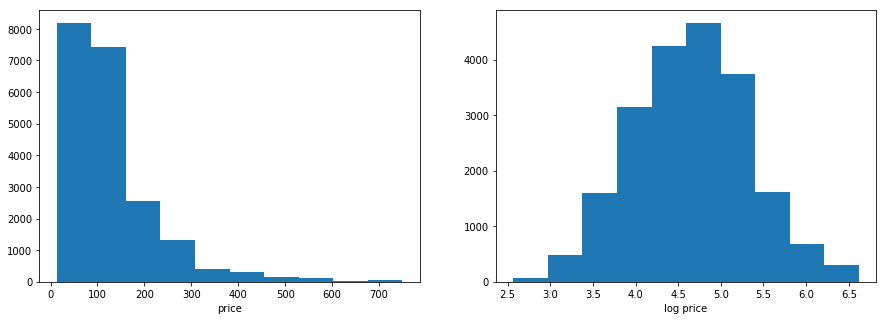

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(df.price)
plt.xlabel('price')
plt.subplot(1,2,2)
plt.hist(df.log_price)
plt.xlabel('log price')
plt.show();

## 3.2 Normalize and Split Dataset

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Here we split the data into the training and test sets, with test size of 0.25.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['log_price','price'],axis=1), 
                                                    df.log_price, test_size=0.25, random_state=1) 

Then, we create a scaler to normalize the training data and use the same scaler to scale the test data.  

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3.3 Linear Regression Model

The firt model we look at is the linear regression model. It is one the the simpliest and most widely used model, and its performance will be used as the baseline other models to compare to.  For simplicity, all features are included for this model.

In [21]:
lm = LinearRegression()

In [22]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [52]:
lm_pred_train = lm.predict(X_train)
lm_pred_test = lm.predict(X_test)

lm_residual = y_test - lm_pred_test
lm_PE_train = np.divide((y_train - lm_pred_train), y_train) *100 
lm_PE_test = np.divide((y_test - lm_pred_test), y_test) *100

metrics_lm_train = ['Train R2',  'Train RMSE','Train AAPE']

lm_train_results = [lm.score(X_train, y_train),
                         np.sqrt(mean_squared_error(y_train, lm_pred_train)),
                         np.mean(np.abs(lm_PE_train))]

for metric, result in zip(metrics_lm_train,lm_train_results):
    print(f'{metric}: {result}')

print()
    
metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
lm_test_results = [lm.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, lm_pred_test)),
                  np.mean(np.abs(lm_PE_test))]

for metric, result in zip(metrics_test,lm_test_results):
    print(f'{metric}: {result}')

Train R2: 0.6845715381461243
Train RMSE: 0.3795138374198794
Train AAPE: 6.354999808294291

Test R^2: 0.6541326077730589
Test RMSE: 0.39581308282654365
Test AAPE: 6.538301785555413


The results shows that the performance metrics for the test data and training data are similar, which means that the model does not significantly overfit the training data. 

Next, we evaluate the model with the test data transformed back to linear scale. 

In [53]:
lm_PE_test_unlog = np.divide(np.exp(y_test) - np.exp(lm_pred_test), np.exp(y_test)) *100

metrics = ['Test R^2', 'Test RMSE', "Test AAPE"]

lm_test_results_unlog = [r2_score(np.exp(y_test), np.exp(lm_pred_test)),
                         np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lm_pred_test))), 
                         np.mean(np.abs(lm_PE_test_unlog))]

for metric, result in zip(metrics_test, lm_test_results_unlog):
    print(f'{metric}: {result}')

Test R^2: 0.4680288574352366
Test RMSE: 73.74494448167053
Test AAPE: 32.195273057990576


After transformation, R^2 drops to 0.468. It is not unsurprising since R^2 is known to variant to variable transformation.

The diagonstics plot for the model (log price) is shown below. While the residual is relatively normally distributed, it shows in increasing trend with log price, meaning the model tends to underpredict at high prices.  
Also, there are a few outliers at the low end of log price, with the model significantly overpredicting the price.

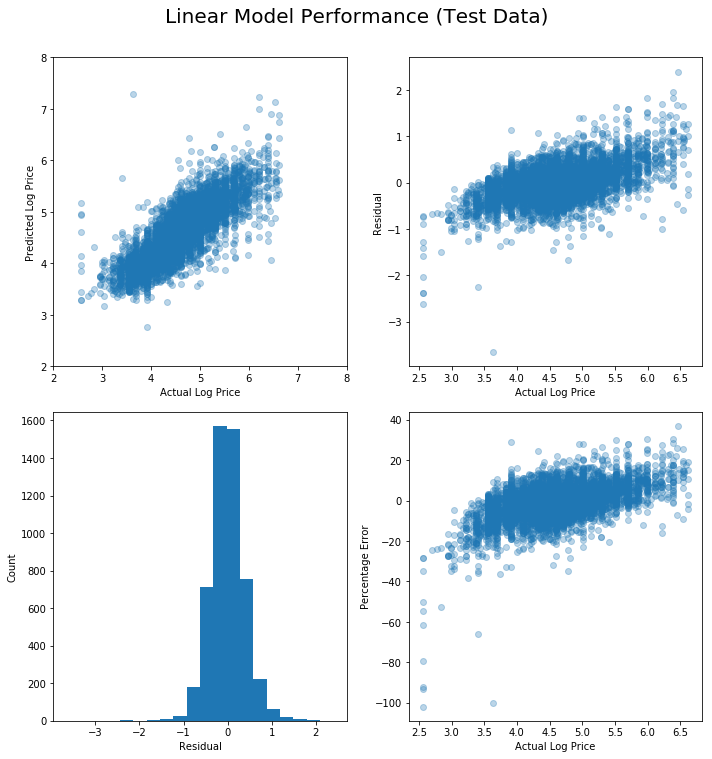

In [25]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(y_test,lm_pred_test, alpha=0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.xlim([2,8])
plt.ylim([2,8])
plt.subplot(2,2,2)
plt.scatter(y_test,lm_residual, alpha = 0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Residual')
plt.subplot(2,2,3)
plt.hist(lm_residual, bins= 20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.scatter(y_test, lm_PE_test, alpha = 0.3)
plt.xlabel('Actual Log Price')
plt.ylabel('Percentage Error')
plt.suptitle('Linear Model Performance (Test Data)',y = 1.05,size=20)
plt.tight_layout()
plt.show()

## 3.4 Random Forest

Next, we evaluate random forest.

In [26]:
from sklearn.ensemble import RandomForestRegressor
from collections import OrderedDict

### 3.4.1 Model Tuning

To build the random forest model, we first select the optimal hyperparameters with model tuning. the two hyperparameters to tune are the number of estimators (n_estimators), and the number of features chosen for each estimator created.  
Using random forest's unique property, after creating each estimator, we use the out-of-bag training data (i.e. data not involved in building that estimator).

In [31]:
RANDOM_STATE = 10
N_ESTIMATORS = 1000
ensemble_models = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(n_estimators= N_ESTIMATORS,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(n_estimators = N_ESTIMATORS,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(n_estimators = N_ESTIMATORS,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))]

oob_r2_dict = OrderedDict((label,[]) for label, _ in ensemble_models)

min_estimators = 50
max_estimators = N_ESTIMATORS

for label, model in ensemble_models:
    for i in range(min_estimators, max_estimators + 1):
        model.set_params(n_estimators = i)
        model.fit(X_train,y_train)
        
        oob_r2 = model.oob_score_
        oob_r2_dict[label].append((i,oob_r2))

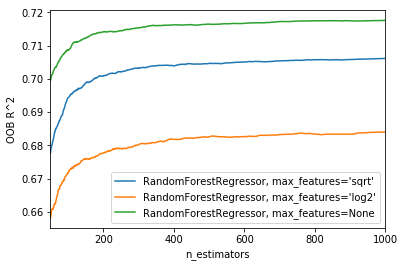

In [32]:
for label, model_r2 in oob_r2_dict.items():
    xs, ys = zip(*model_r2)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB R^2")
plt.legend(loc="lower right")
plt.savefig('rf_oob_1000.png')
plt.show()

From the graph above, the best maximum features setting is "None".  The performance does not improve significantly with no. of estimators above 500, so we decide to cap the number of estimator at that value.

### 3.4.2 Model Development and Evaluation

In [28]:
RANDOM_STATE = 10
rf = RandomForestRegressor(max_features=None,n_estimators=500, random_state = RANDOM_STATE)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [54]:
rf_pred_test = rf.predict(X_test)

rf_residual = y_test - rf_pred_test
rf_PE_test = np.divide((y_test - rf_pred_test), y_test) *100


rf_test_results = [rf.score(X_test, y_test),np.sqrt(mean_squared_error(y_test, rf_pred_test)),
                  np.mean(np.abs(rf_PE_test))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,rf_test_results):
    print(f'{metric}: {result}')


Test R^2: 0.7084506909934403
Test RMSE: 0.3634053723729523
Test AAPE: 5.862479230954941


We also look at model performance with target varaible transformed back to linear scale (i.e. price).

In [55]:
rf_PE_test_unlog = np.divide(np.exp(y_test) - np.exp(rf_pred_test), np.exp(y_test)) *100

rf_test_results_unlog = [r2_score(np.exp(y_test), np.exp(rf_pred_test)),
                         np.sqrt(mean_squared_error(np.exp(y_test), np.exp(rf_pred_test))), 
                         np.mean(np.abs(rf_PE_test_unlog))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,rf_test_results_unlog):
    print(f'{metric}: {result}')

Test R^2: 0.6075607397038529
Test RMSE: 63.33947220758271
Test AAPE: 28.52110488225404


The random forest model shows improvement to the linear regression model.

The diagnostics plot of the random forest model is shown below. It is similar to that of the linear model.

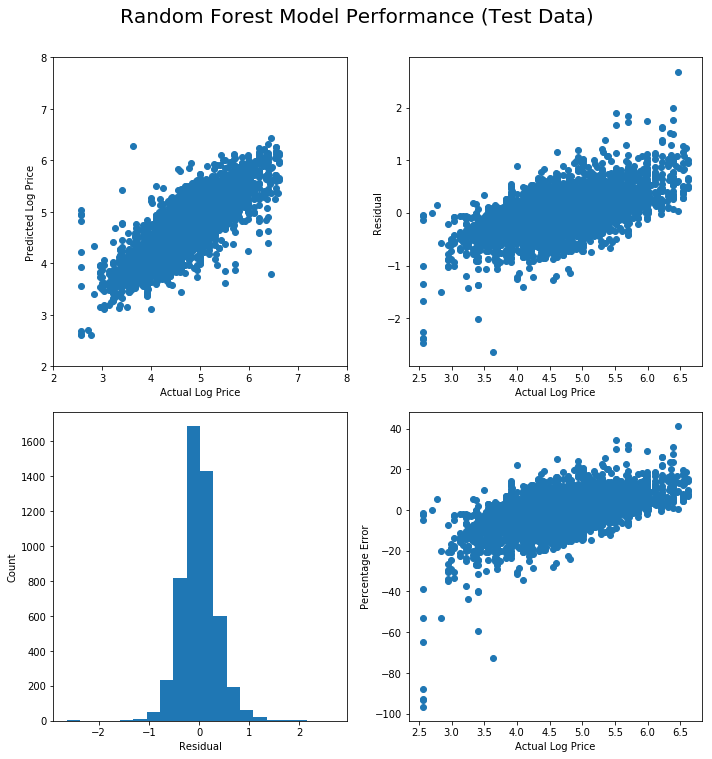

In [56]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(y_test,rf_pred_test)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.xlim([2,8])
plt.ylim([2,8])
plt.subplot(2,2,2)
plt.scatter(y_test,rf_residual)
plt.xlabel('Actual Log Price')
plt.ylabel('Residual')
plt.subplot(2,2,3)
plt.hist(rf_residual, bins=20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.scatter(y_test, rf_PE_test)
plt.xlabel('Actual Log Price')
plt.ylabel('Percentage Error')
plt.suptitle('Random Forest Model Performance (Test Data)',y = 1.05, size=20)
plt.tight_layout()
plt.show()

The graph below shows that by far the most important feature is room type (entire home/apartment). Some interesting features make the top 20 list, e.g. availabilities of listing, and the days since the first and last reviews. Also no amenities make the top 20 list. 

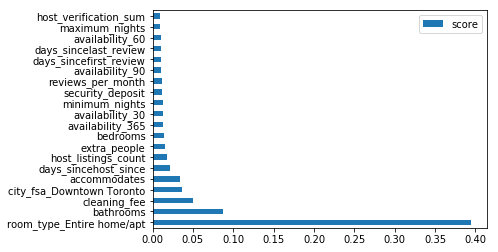

In [57]:
rf_feature_importances = pd.DataFrame({'score':rf.feature_importances_},index = df.drop(['price','log_price'],axis=1).columns)
rf_feature_importances.sort_values('score',ascending=False)[:20].plot.barh();

## 3.5 Gradient boosting

In gradient boosting, estimators are built sequentially, with the an estimator fit to the residuals produced by the preceding estimator.

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

### 3.5.1 Model tuning

We use grid search to determine the best hyperparameters. The hyperparameters being tuned are learning rate, max depth of trees, and the number of features considered for each tree.

In [34]:
## Grid Search with CV

RANDOM_STATE = 10

gb = GradientBoostingRegressor(warm_start = True, random_state = RANDOM_STATE)
param_grid = {'learning_rate':[0.01 ,0.1, 1], 'n_estimators':[500],
              'max_depth': [2, 5], 'max_features' :[None, 'sqrt','log2']}
cv_gb = GridSearchCV(estimator=gb,param_grid=param_grid,cv=5)
cv_gb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1, 1], 'n_estimators': [500], 'max_depth': [2, 5], 'max_features': [None, 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
The best hyperparameters are shown below. 

In [58]:
gb_best_params = cv_gb.best_params_
gb_best_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 500}

### 3.5.2 Model Development and Evaluation

In [59]:
# Build GBM model
gb = GradientBoostingRegressor(learning_rate=gb_best_params['learning_rate'],
                               max_depth=gb_best_params['max_depth'],
                               max_features = gb_best_params['max_features'],
                               n_estimators = gb_best_params['n_estimators'],warm_start=True, random_state=RANDOM_STATE)
gb.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=True)

In [61]:
gb_pred_test = gb.predict(X_test)
gb_residual = y_test - gb_pred_test
gb_PE_test = np.divide((y_test - gb_pred_test), y_test) *100

gb_test_results = [gb.score(X_test, y_test),np.sqrt(mean_squared_error(y_test, gb_pred_test)),
                  np.mean(np.abs(gb_PE_test))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,gb_test_results):
    print(f'{metric}: {result}')

Test R^2: 0.7257626025600867
Test RMSE: 0.35245094108173847
Test AAPE: 5.671971023539582


The model shows slight improvement over the random forest model with higher R^2, and lower RMSE and AAPE.

Similiarly, we also look at the performance on price.

In [63]:
gb_PE_test_unlog = np.divide(np.exp(y_test) - np.exp(gb_pred_test), np.exp(y_test)) *100

gb_test_results_unlog = [r2_score(np.exp(y_test), np.exp(gb_pred_test)),
                         np.sqrt(mean_squared_error(np.exp(y_test), np.exp(gb_pred_test))), 
                         np.mean(np.abs(gb_PE_test_unlog))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,gb_test_results_unlog):
    print(f'{metric}: {result}')

Test R^2: 0.6376086282811575
Test RMSE: 60.86633337828029
Test AAPE: 27.670967813767977


Again, it shows slight improvement over the random forest model.

The diagnostics plot for the model is shown below.

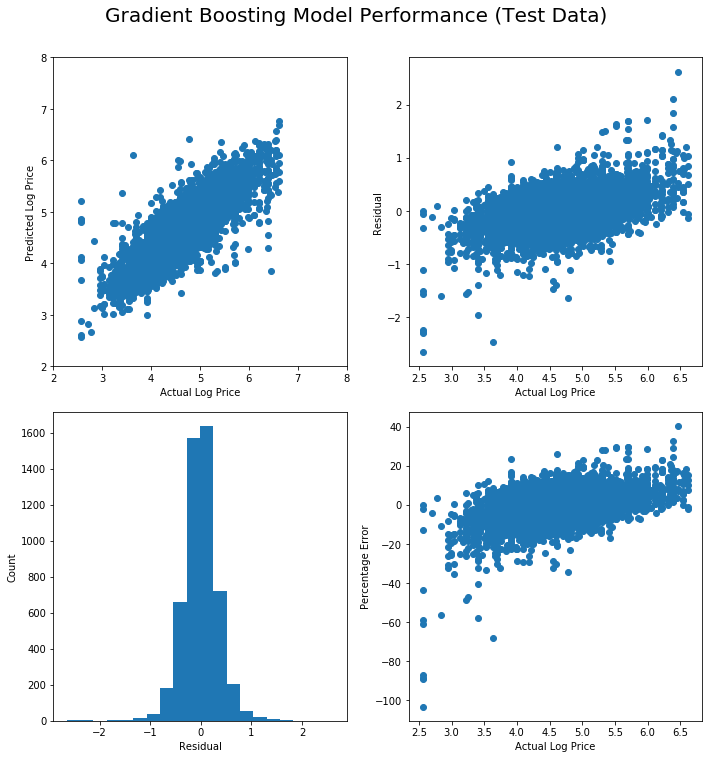

In [64]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(y_test,gb_pred_test)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.xlim([2,8])
plt.ylim([2,8])
plt.subplot(2,2,2)
plt.scatter(y_test,gb_residual)
plt.xlabel('Actual Log Price')
plt.ylabel('Residual')
plt.subplot(2,2,3)
plt.hist(gb_residual, bins=20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.scatter(y_test, gb_PE_test)
plt.xlabel('Actual Log Price')
plt.ylabel('Percentage Error')
plt.suptitle('Gradient Boosting Model Performance (Test Data)',y = 1.05, size=20)
plt.tight_layout()
plt.show()

The feature importance plot shows that the "days" features are the most important. Also, compared to random forest, the relative importances are more comparable among features.  

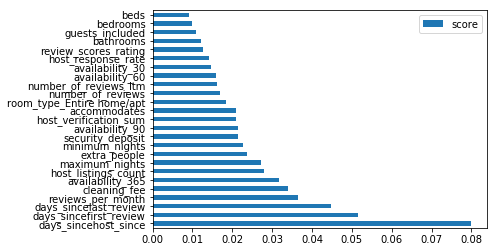

In [65]:
gb_feature_importances = pd.DataFrame({'score':gb.feature_importances_},index = df.drop(['price','log_price'],axis=1).columns)
gb_feature_importances.sort_values('score',ascending=False)[:25].plot.barh();

## 3.6 XGBoost

Next, we loook at XGBoost. In essence, XGBoost is gradient boosting with regularization to control model complexity.  

In [35]:
import xgboost as xgb

In [67]:
xg = xgb.XGBRegressor(random_state=10)
xg_param_grid = {'colsample_bytree': [0.5, 0.75, 1], 'n_estimators': [500], 'max_depth': [2, 5]}

xg_cv = GridSearchCV(estimator=xg,param_grid=xg_param_grid,cv=5,verbose=1)

In [68]:
xg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 26.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'colsample_bytree': [0.5, 0.75, 1], 'n_estimators': [500], 'max_depth': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

The best parameters are shown below.

In [74]:
xg_best_params = xg_cv.best_params_
xg_best_params

{'colsample_bytree': 0.5, 'max_depth': 5, 'n_estimators': 500}

In [71]:
xg = xgb.XGBRegressor(colsample_bytree = xg_best_params['colsample_bytree'], n_estimators = xg_best_params['n_estimators'],
                 max_depth = xg_best_params['max_depth'])

xg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [73]:
xg_pred_test = xg.predict(X_test)
xg_residual = y_test - xg_pred_test
xg_PE_test = np.divide((y_test - xg_pred_test), y_test) *100

xg_test_results = [xg.score(X_test, y_test),np.sqrt(mean_squared_error(y_test, xg_pred_test)),
                  np.mean(np.abs(xg_PE_test))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,xg_test_results):
    print(f'{metric}: {result}')

Test R^2: 0.7319055389230438
Test RMSE: 0.3484811215852977
Test AAPE: 5.634049636017046


The result shows slight improvement to gradient boosting.

Similarly, we'll also look at the performance on price.

In [75]:
xg_PE_test_unlog = np.divide(np.exp(y_test) - np.exp(xg_pred_test), np.exp(y_test)) *100

xg_test_results_unlog = [r2_score(np.exp(y_test), np.exp(xg_pred_test)),
                         np.sqrt(mean_squared_error(np.exp(y_test), np.exp(xg_pred_test))), 
                         np.mean(np.abs(xg_PE_test_unlog))]

metrics_test = ['Test R^2',  'Test RMSE','Test AAPE']
    
for metric, result in zip(metrics_test,xg_test_results_unlog):
    print(f'{metric}: {result}')

Test R^2: 0.6438672844039541
Test RMSE: 60.33845027462327
Test AAPE: 27.360561732242367


The diagnostic plots are shown below. 

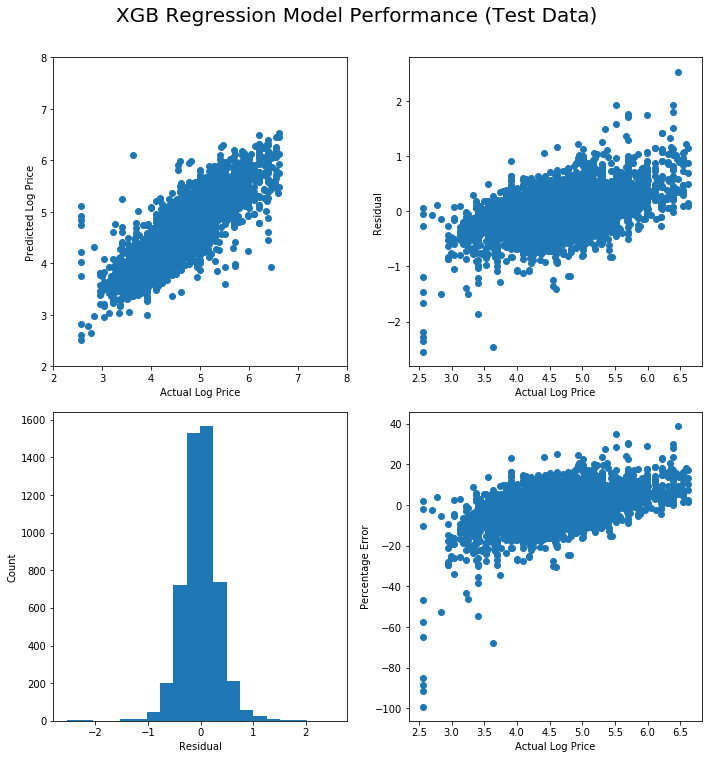

In [76]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(y_test,xg_pred_test)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.xlim([2,8])
plt.ylim([2,8])
plt.subplot(2,2,2)
plt.scatter(y_test,xg_residual)
plt.xlabel('Actual Log Price')
plt.ylabel('Residual')
plt.subplot(2,2,3)
plt.hist(xg_residual, bins=20)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.subplot(2,2,4)
plt.scatter(y_test, xg_PE_test)
plt.xlabel('Actual Log Price')
plt.ylabel('Percentage Error')
plt.suptitle('XGB Regression Model Performance (Test Data)',y = 1.05, size=20)
plt.tight_layout()
plt.show()

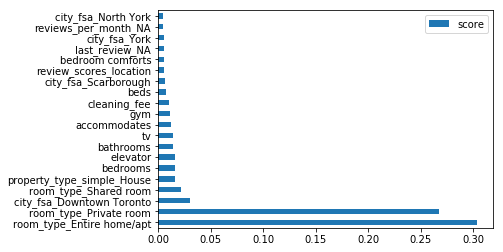

In [77]:
xg_feature_importances = pd.DataFrame({'score':xg.feature_importances_},index = df.drop(['price','log_price'],axis=1).columns)
xg_feature_importances.sort_values('score',ascending=False)[:20].plot.barh();

In [ ]:
Based on the model, the most important featuers are room type. Also, in this model, a few of amenities make to the top 20 list. 

## 3.7 Model Comparison

In [ ]:
We compare the models based on their performances on predicting both the log price and the actual price.  

In [79]:
summary = OrderedDict({"Linear Regression": lm_test_results, "Random Forest": rf_test_results,
                                   'Gradient Boosting': gb_test_results, "XG Boosting": xg_test_results})
df_model_comparison = pd.DataFrame(summary, index=['R^2','RMSE','AAPE'])
print("Model Performances (Log Price)")
df_model_comparison

Model Performances (Log Price)


,Linear Regression,Random Forest,Gradient Boosting,XG Boosting
R^2,0.654133,0.708451,0.725763,0.731906
RMSE,0.395813,0.363405,0.352451,0.348481
AAPE,6.538302,5.862479,5.671971,5.634050


In [80]:
summary = OrderedDict({"Linear Regression": lm_test_results_unlog, "Random Forest": rf_test_results_unlog,
                                   'Gradient Boosting': gb_test_results_unlog, "XG Boosting": xg_test_results_unlog})
df_model_comparison = pd.DataFrame(summary, index=['R^2','RMSE','AAPE'])
print("Model Performances (Price)")
df_model_comparison

Model Performances (Log Price)


,Linear Regression,Random Forest,Gradient Boosting,XG Boosting
R^2,0.468029,0.607561,0.637609,0.643867
RMSE,73.744944,63.339472,60.866333,60.338450
AAPE,32.195273,28.521105,27.670968,27.360562


Overall, all three advanced model shows significant improvement to simple linear regression. XG boost is the best model, edging out random forest and gradient boosting for performance.  

# 4. Summary

In this section, we developed and compared four maching learing model to predict price for a listing.  
- The simple linear model, with all features included, does not overfit the data as its performances on training data and test data are similar.
- The advanced models, which include random forest, gradient boosting, and XGB regression, all show significant improvements.
- XGB regression has the best performance.